In [7]:
import numpy as np
from pathlib import Path

import scipy.io as sio
from scipy.ndimage import gaussian_filter1d
from scipy.signal import resample_poly

import matplotlib.pyplot as plt
from matplotlib.path import Path as mPath
import matplotlib.ticker as mticker
from matplotlib.patches import Rectangle

from utils import load_pickle,extract_used_data,mergeAB,set_params
from utils.config import Params

import ipywidgets as widgets
from IPython.display import display

In [8]:
def smooth_and_downsample(data: np.ndarray, params: Params, axis: int):
    data = gaussian_filter1d(data, sigma=params.gaussian_sigma, axis=axis, mode='nearest', truncate=3.0)
    k = params.len_pos_average
    len_track = data.shape[axis]
    slices = [slice(None)] * data.ndim
    slices[axis] = slice(0, len_track - len_track % k)
    data = data[tuple(slices)]
    data = resample_poly(data, up=1, down=k, axis=axis)
    return data


def extract_trial_speed(data, params: Params, speeds: np.ndarray):
    
    trials = []
    
    speeds = smooth_and_downsample(speeds, params, axis=1)

    for i in range(data['shape'][0]):
        for j in range(data['shape'][1]):
            
            fr = data['simple_firing'][i,j]
            if fr is None:
                continue
            
            fr = smooth_and_downsample(fr, params, axis=2)
            
            shape_ij = fr.shape
            num_trails = shape_ij[1]
            
            indexes = data['type_index'][i,j]
            
            for k in range(num_trails):
                
                trial_data = {
                    'trial_type': params.tt[i],
                    'behavior_type': params.bt[j],
                    'firing': fr[:,k,:],
                    'index': indexes[k],
                    'lick': data['pos_lick_type'][i,j][k],
                    'reward': data['pos_reward_type'][i,j][k],
                    'speed': speeds[indexes[k]],
                    'zones': data['zones'],
                }
                
                trials.append(trial_data)
                
    trials.sort(key=lambda t: t['index'])
    
    assert len(trials) == speeds.shape[0], "Mismatch between trials and speeds"
    
    return trials

def get_data_in_row(entry_dir: str, params: Params):
    path = Path(entry_dir)
    data_dict = {}
    speed_dict = {}
    for file in path.glob("*.pkl"):
        name = file.stem.replace("PFCsep","")
        name = name.rstrip("-")
        mat_file_path = file.parent / "speed" / f"{name}.mat"
        data = load_pickle(file)
        data = extract_used_data(data)
        mergeAB(data)
        data_dict[name] = data
        try:
            if mat_file_path.exists():
                mat_data = sio.loadmat(mat_file_path)
                speeds = mat_data["speed_interp_trials"]
                speeds = np.squeeze(speeds)
                assert len(speeds.shape) == 1, "Unexpected speed data shape"
                speeds = np.array([np.squeeze(speeds[i]) for i in range(speeds.shape[0])])
                speed_dict[name] = speeds
            else:
                print(f"Missing file: {mat_file_path}")
        except Exception as e:
            print(f"Failed to load mat file {mat_file_path}: {e}")
    trials_all = []
    trials_dict = {}
    for key in data_dict.keys():
        trials_dict[key] = extract_trial_speed(data_dict[key], params, speed_dict[key])
        trials_all.extend(trials_dict[key])
       
    return trials_all, trials_dict
       
def plot_speed(trials, params: Params, ana_tt: list, ana_bt: list):
    
    color_map = {
        "pattern_1": "#1f77b4",
        "pattern_2": "#ff7f0e",
        "pattern_3": "#d62728",
        "position_1": "#1f77b4",
        "position_2": "#ff7f0e",
        "position_3": "#d62728",
    }
    
    zones = trials[0]['zones']
    
    fig = plt.figure(figsize=(5, 3))
    ax = fig.gca()
    
    for index in params.ana_index_grid(ana_tt, ana_bt):
        
        trial_type = params.tt[index[0]]
        behavior_type = params.bt[index[1]]
        
        selected_trials = [t for t in trials if t['trial_type'] == trial_type and t['behavior_type'] == behavior_type]
        if len(selected_trials) == 0:
            continue

        speeds = [t['speed'] for t in selected_trials]
        speeds = np.array(speeds)
        
        mean_speed = np.mean(speeds, axis=0)
        std_speed = np.std(speeds, axis=0) / np.sqrt(speeds.shape[0])
        
        c = color_map.get(trial_type, "#000000")
        X = np.arange(mean_speed.shape[0])
        
        ax.plot(X, mean_speed, color=c, linewidth=1.5)
        ax.fill_between(X, mean_speed - std_speed, mean_speed + std_speed, color=c, alpha=0.3)
    
    ax.set_xlabel("Position (cm)", fontsize=12)
    ax.set_ylabel("Speed (cm/s)", fontsize=12)
    ax.tick_params(axis='both', labelsize=12)
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f'{x*params.space_unit*params.len_pos_average:g}'))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
        
    plt.tight_layout()
    plt.show()
    

In [9]:
entry_dir = "../../data/first_to_pos"
params = set_params(tt_preset='merge',
                    bt_preset='basic',
                    len_pos_average=1,
                    gaussian_sigma=50)
trials_all, trials_dict = get_data_in_row(entry_dir, params)

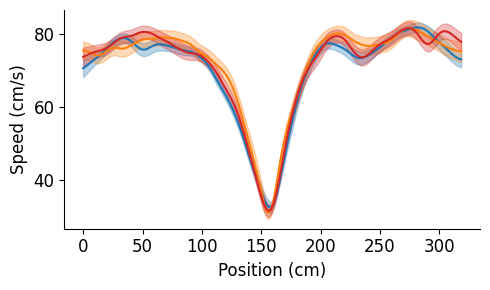

In [10]:
plot_speed(trials_all, params, ana_tt=['position*'], ana_bt=['correct'])

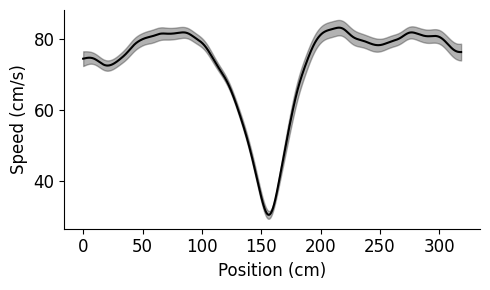

In [11]:
plot_speed(trials_all, params, ana_tt=['couple*'], ana_bt=['correct'])

In [12]:
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.ticker as mticker
# import ipywidgets as widgets
# from IPython.display import display, clear_output
# from matplotlib.patches import Rectangle


# def plot_trial_speed(
#     trial: dict,
#     params,
#     ax=None,
#     alpha=0.95,
#     lw=1.5,
#     show_zones=True,
#     zones_color=None,
# ):

#     if zones_color is None:
#         zones_color = {0: "#1f77b4", 2: "#ff7f0e", 4: "#d62728"}  # 你原先那套

#     speed = np.asarray(trial["speed"]).squeeze()
#     if speed.ndim != 1:
#         raise ValueError(f"Expect 1D speed for each trial, got {speed.shape}")

#     if ax is None:
#         fig, ax = plt.subplots(figsize=(5, 3))
#     else:
#         fig = ax.figure

#     X = np.arange(speed.shape[0])
#     ax.plot(X, speed, linewidth=lw, alpha=alpha)

#     if show_zones and ("zones" in trial) and (trial["zones"] is not None):
#         zones = trial["zones"]
#         h_frac = 0.06 
#         for zi, row in enumerate(zones):
#             if zi not in zones_color:
#                 continue
#             if row is None or len(row) < 2:
#                 continue
#             try:
#                 start_x = row[0] / params.space_unit / params.len_pos_average
#                 end_x   = row[1] / params.space_unit / params.len_pos_average
#             except Exception:
#                 continue

#             ax.axvline(start_x, linestyle="--", color="k", linewidth=0.8)
#             ax.axvline(end_x,   linestyle="--", color="k", linewidth=0.8)

#             rect = Rectangle(
#                 (start_x, 1.0 - h_frac),
#                 end_x - start_x,
#                 h_frac,
#                 transform=ax.get_xaxis_transform(),
#                 facecolor=zones_color[zi],
#                 edgecolor="none",
#                 clip_on=False,
#                 zorder=6,
#             )
#             ax.add_patch(rect)

#     ax.set_xlabel("Position (cm)", fontsize=12)
#     ax.set_ylabel("Speed (cm/s)", fontsize=12)
#     ax.tick_params(axis="both", labelsize=12)
#     ax.xaxis.set_major_formatter(
#         mticker.FuncFormatter(lambda x, pos: f"{x * params.space_unit * params.len_pos_average:g}")
#     )
#     ax.spines["top"].set_visible(False)
#     ax.spines["right"].set_visible(False)
#     ax.xaxis.set_ticks_position("bottom")
#     ax.yaxis.set_ticks_position("left")

#     title = (f"trial_index={trial.get('index')} | "
#              f"{trial.get('trial_type')} | {trial.get('behavior_type')}")
#     ax.set_title(title, fontsize=10)

#     return fig, ax


# def browse_trial_speeds(
#     trials: list,
#     params,
#     trial_filter=None,
#     start=0,
#     show_zones=True,
# ):

#     selected = trials if trial_filter is None else [t for t in trials if trial_filter(t)]
#     if len(selected) == 0:
#         raise ValueError("No trials selected (after filter).")

#     slider = widgets.IntSlider(
#         value=int(np.clip(start, 0, len(selected) - 1)),
#         min=0, max=len(selected) - 1, step=1,
#         description="Trial #",
#         continuous_update=False,
#     )
#     btn_prev = widgets.Button(description="◀ Prev", layout=widgets.Layout(width="80px"))
#     btn_next = widgets.Button(description="Next ▶", layout=widgets.Layout(width="80px"))
#     out = widgets.Output()

#     def render(_=None):
#         with out:
#             clear_output(wait=True)
#             # 画当前 trial
#             fig, ax = plt.subplots(figsize=(5, 3))
#             plot_trial_speed(selected[slider.value], params, ax=ax, show_zones=show_zones)
#             plt.tight_layout()
#             plt.show()
#             plt.close(fig)  # 防止 widget 反复渲染累积 figure

#     def on_prev(_):
#         slider.value = max(slider.min, slider.value - 1)

#     def on_next(_):
#         slider.value = min(slider.max, slider.value + 1)

#     btn_prev.on_click(on_prev)
#     btn_next.on_click(on_next)
#     slider.observe(render, names="value")

#     display(widgets.HBox([btn_prev, slider, btn_next]), out)
#     render()
